In [51]:
# imporing the libraries
#calculating the run time of entire code
import time
start = time.time()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
#Importing the opendatasets library to download datasets directly into the notebook
#skip this step if you have already downloaded the dataset
!pip install opendatasets --upgrade --quiet
import opendatasets as od


In [53]:
od.download("https://www.kaggle.com/datasets/whenamancodes/real-or-fake-jobs?select=fake_job_postings.csv")

Skipping, found downloaded files in "./real-or-fake-jobs" (use force=True to force download)


In [54]:
#Loading the dataset
df = pd.read_csv('./real-or-fake-jobs/fake_job_postings.csv')

In [185]:
#displaying the first 5 rows
df.head()
#printing the shape of the dataset
print(df.shape)
df.info()

(17853, 20)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17853 entries, 0 to 17879
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                17853 non-null  object  
 1   location             17509 non-null  object  
 2   department           6330 non-null   object  
 3   company_profile      17853 non-null  object  
 4   description          17853 non-null  object  
 5   requirements         17853 non-null  object  
 6   benefits             17853 non-null  object  
 7   telecommuting        17853 non-null  bool    
 8   has_company_logo     17853 non-null  bool    
 9   has_questions        17853 non-null  bool    
 10  employment_type      17853 non-null  category
 11  required_experience  17853 non-null  category
 12  required_education   17853 non-null  category
 13  industry             17853 non-null  category
 14  function             17853 non-null  category
 15  fraudul

In [56]:
#looking at unique values in each column
df.nunique()
#changing the telecommuting, has_company_logo, has_questions, fraudulent columns to boolean
df['telecommuting'] = df['telecommuting'].astype(bool)
df['has_company_logo'] = df['has_company_logo'].astype(bool)
df['has_questions'] = df['has_questions'].astype(bool)
df['fraudulent'] = df['fraudulent'].astype(bool)

In [57]:
#checking the data types
df.info()
df.nunique()
#changing required_experience, required_education, employment_type, industry, function, fraudulent to category
df['required_experience'] = df['required_experience'].astype('category')
df['required_education'] = df['required_education'].astype('category')
df['employment_type'] = df['employment_type'].astype('category')
df['industry'] = df['industry'].astype('category')
df['function'] = df['function'].astype('category')
df['fraudulent'] = df['fraudulent'].astype('category')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  bool  
 10  has_company_logo     17880 non-null  bool  
 11  has_questions        17880 non-null  bool  
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [58]:
#dropping the job_id column
df.drop('job_id', axis=1, inplace=True)

In [59]:
#splitting salary_range into minimum and maximum salary columns and dropping the salary_range column
def split_salary_range(df):
    df['minimum_salary'] = df['salary_range'].str.split('-', expand=True)[0]
    df['maximum_salary'] = df['salary_range'].str.split('-', expand=True)[1]
    df.drop('salary_range', axis=1, inplace=True)
    return df
split_salary_range(df)

In [60]:
#changing minimum_salary and maximum_salary to float like df['CIP'] = df['CIP'].str.replace('\.0*$', '', regex=True)
df['minimum_salary'] = df['minimum_salary'].astype(str).str.replace('\.0*$', '', regex=True)
df['maximum_salary'] = df['maximum_salary'].astype(str).str.replace('\.0*$', '', regex=True)
# finding the rows with 'Oct','Jun','Dec' as a vale in minimum_salary and maximum_salary column and dropping them
df = df[~df['minimum_salary'].isin(['Oct','Jun','Dec','Apr','Sep','Mar','Aug','Jul','May','Nov','Feb','Jan','None'])]
df = df[~df['maximum_salary'].isin(['Oct','Jun','Dec','Apr','Sep','Mar','Aug','Jul','May','Nov','Feb','Jan','None'])]
#converting minimum_salary and maximum_salary to float
df['minimum_salary'] = df['minimum_salary'].astype(float)
df['maximum_salary'] = df['maximum_salary'].astype(float)




In [61]:
#extracting the country from location column
def extract_country(location):
    return location.split(',')[0]
df['country'] = df['location'].apply(extract_country)


In [62]:
#extracting keywords from title and description
df['keywords'] = df['title'] + ' ' + df['description']
#changing keywords to string
df['keywords'] = df['keywords'].astype(str)
#removing the special characters from keywords
df['keywords'] = df['keywords'].str.replace('[^\w\s]','')
#removing the stopwords from keywords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['keywords'] = df['keywords'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#removing the rare words from keywords
freq = pd.Series(' '.join(df['keywords']).split()).value_counts()[-10:]
freq = list(freq.index)
df['keywords'] = df['keywords'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
#removing the common words from keywords
freq = pd.Series(' '.join(df['keywords']).split()).value_counts()[:10]
freq = list(freq.index)
df['keywords'] = df['keywords'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
#removing the numbers from keywords
df['keywords'] = df['keywords'].str.replace('\d+', '')
#removing the single characters from keywords
df['keywords'] = df['keywords'].apply(lambda x: " ".join(x for x in x.split() if len(x)>1))
#removing the words with length less than 3 from keywords
df['keywords'] = df['keywords'].apply(lambda x: " ".join(x for x in x.split() if len(x)>3))
#removing the words with length greater than 15 from keywords
df['keywords'] = df['keywords'].apply(lambda x: " ".join(x for x in x.split() if len(x)<15))


/tmp/ipykernel_3302/1581412603.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['keywords'] = df['keywords'].str.replace('[^\w\s]','')
[nltk_data] Downloading package stopwords to /home/m97/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_3302/1581412603.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['keywords'] = df['keywords'].str.replace('\d+', '')


In [63]:
#removing the special characters from title
df['title'] = df['title'].str.replace('[^\w\s]','')
#removing the stopwords from title
df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#doing the same for company_profile, description, requirements, benefits
df['company_profile'] = df['company_profile'].str.replace('[^\w\s]','')
df['company_profile'] = df['company_profile'].astype(str).apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['description'] = df['description'].str.replace('[^\w\s]','')
df['description'] = df['description'].astype(str).apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['requirements'] = df['requirements'].str.replace('[^\w\s]','')
df['requirements'] = df['requirements'].astype(str).apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['benefits'] = df['benefits'].str.replace('[^\w\s]','')
df['benefits'] = df['benefits'].astype(str).apply(lambda x: " ".join(x for x in x.split() if x not in stop))

/tmp/ipykernel_3302/1548050101.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title'] = df['title'].str.replace('[^\w\s]','')
/tmp/ipykernel_3302/1548050101.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['company_profile'] = df['company_profile'].str.replace('[^\w\s]','')
/tmp/ipykernel_3302/1548050101.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['description'] = df['description'].str.replace('[^\w\s]','')
/tmp/ipykernel_3302/1548050101.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['requirements'] = df['requirements'].str.replace('[^\w\s]','')
/tmp/ipykernel_3302/1548050101.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['benefits'] = df['benefits'].str.replace('[^\w\s]','')


In [64]:
#dropping unwanted variables like stop and freq
del stop, freq

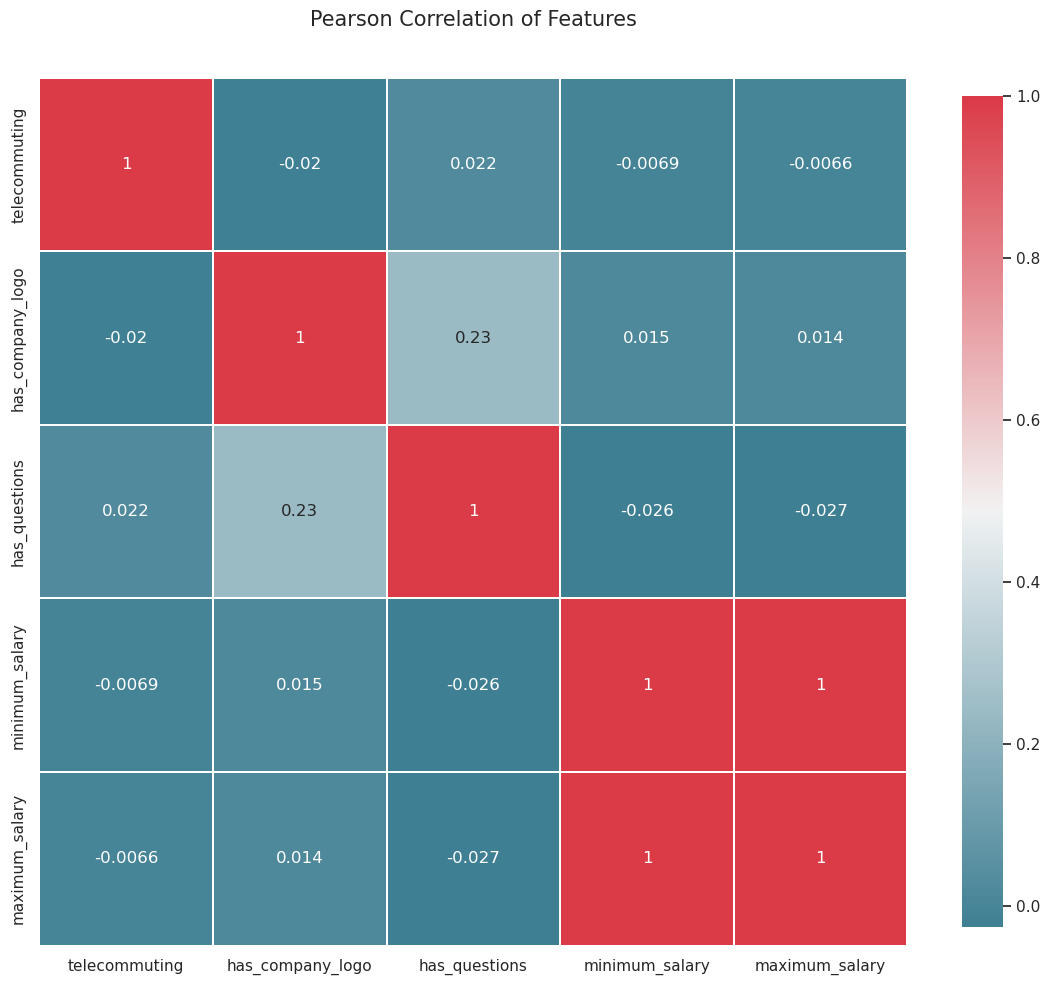

In [195]:
#corolation matrix for the dataset ignoring nan values and categorical values
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
correlation_heatmap(df)

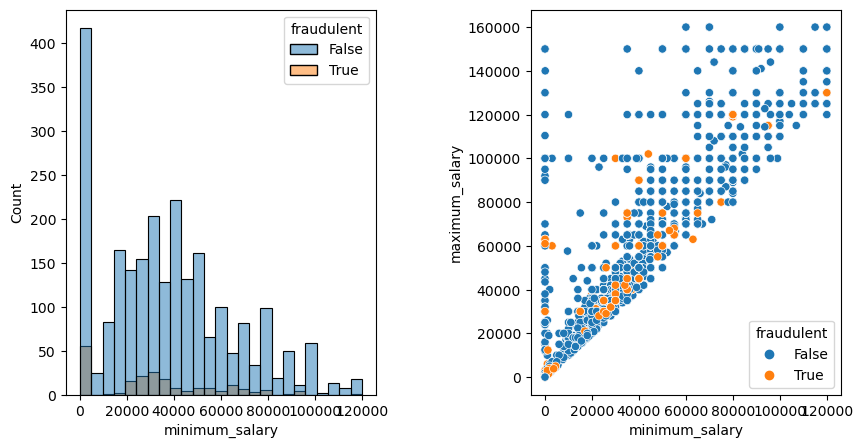

In [66]:
#create a new dataframe with only the numerical columns and the target column
df1 = df[['minimum_salary','maximum_salary','fraudulent']]
#removing the rows with nan values
df1 = df1.dropna()
#deal with the outliers in the minimum_salary column using the IQR method
Q1 = df1['minimum_salary'].quantile(0.25)
Q3 = df1['minimum_salary'].quantile(0.75)
IQR = Q3 - Q1
df1 = df1[~((df1['minimum_salary'] < (Q1 - 1.5 * IQR)) |(df1['minimum_salary'] > (Q3 + 1.5 * IQR)))]
#deal with the outliers in the maximum_salary column using the IQR method
Q1 = df1['maximum_salary'].quantile(0.25)
Q3 = df1['maximum_salary'].quantile(0.75)
IQR = Q3 - Q1
df1 = df1[~((df1['maximum_salary'] < (Q1 - 1.5 * IQR)) |(df1['maximum_salary'] > (Q3 + 1.5 * IQR)))]
#plotting the scatter plot for the maximum_salary and minimum_salary columns with the target column
#plotting the histogram for the maximum_salary and minimum_salary columns with the target column
#ploting two plots in one figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# spacing between subplots
fig.subplots_adjust(wspace=0.5)
sns.histplot(x='minimum_salary', hue='fraudulent', data=df1, ax=ax1)
sns.scatterplot(x='minimum_salary', y='maximum_salary', hue='fraudulent', data=df1, ax=ax2)

del df1, Q1, Q3, IQR

In [67]:
#using the label encoder to convert the categorical columns to numerical columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['employment_type'] = le.fit_transform(df['employment_type'])
df['required_experience'] = le.fit_transform(df['required_experience'])
df['required_education'] = le.fit_transform(df['required_education'])
df['industry'] = le.fit_transform(df['industry'])
df['function'] = le.fit_transform(df['function'])
df['fraudulent'] = le.fit_transform(df['fraudulent'])

del le

In [68]:
#changing required_experience, required_education, employment_type, industry, function, fraudulent to category
df['required_experience'] = df['required_experience'].astype('category')
df['required_education'] = df['required_education'].astype('category')
df['employment_type'] = df['employment_type'].astype('category')
df['industry'] = df['industry'].astype('category')
df['function'] = df['function'].astype('category')
df['fraudulent'] = df['fraudulent'].astype('category')
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 17853 entries, 0 to 17879
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                17853 non-null  object  
 1   location             17509 non-null  object  
 2   department           6330 non-null   object  
 3   company_profile      17853 non-null  object  
 4   description          17853 non-null  object  
 5   requirements         17853 non-null  object  
 6   benefits             17853 non-null  object  
 7   telecommuting        17853 non-null  bool    
 8   has_company_logo     17853 non-null  bool    
 9   has_questions        17853 non-null  bool    
 10  employment_type      17853 non-null  category
 11  required_experience  17853 non-null  category
 12  required_education   17853 non-null  category
 13  industry             17853 non-null  category
 14  function             17853 non-null  category
 15  fraudulent         

/home/m97/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[3385   17]
 [  55  114]]
Accuracy:  0.9798375805096612
Precision:  0.8702290076335878


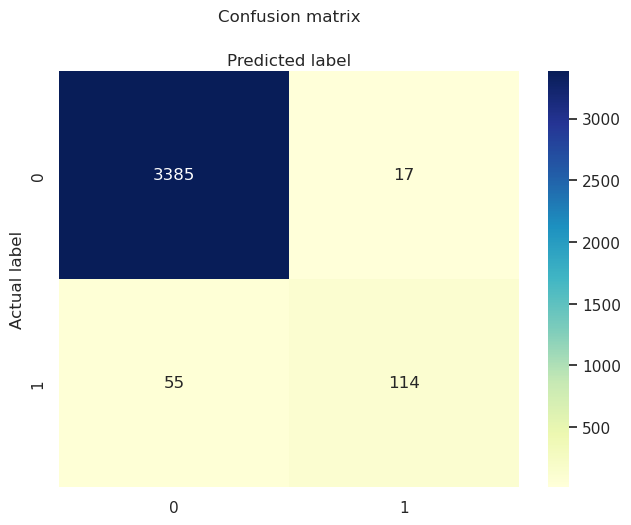

In [191]:
#using the count vectorizer to convert the keywords to numerical values
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df['keywords'])
y = df['fraudulent']
#splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# using a logistic regression model to train the dataset and predict the target column
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
#calculating spicity, sensitivity, accuracy, precision, recall, f1 score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
# saving the accuracy and precision score and recall score and f1 score in a dictionary
scores = {'accuracy': accuracy_score(y_test, y_pred), 'precision': precision_score(y_test, y_pred), 'recall': recall_score(y_test, y_pred), 'f1': f1_score(y_test, y_pred)}
#saving the model
import pickle
pickle.dump(lr, open('model.pkl','wb'))
#visiualizing the logistic regression model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=['Not Fraudulent', 'Fraudulent'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
del X, y, X_train, X_test, y_train, y_test, y_pred, cm, cnf_matrix, class_names, fig, ax, tick_marks

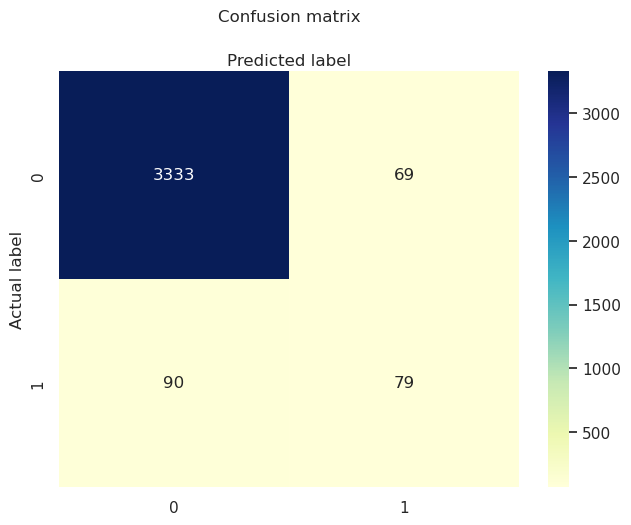

In [193]:
#naive bayes classifier
#using keyword as the feature and fraudulent as the target
#using the count vectorizer to convert the keywords to numerical values
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df['keywords'])
y = df['fraudulent']
#splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#using the multinomial naive bayes classifier to train the model
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
#saving the model
import pickle
pickle.dump(mnb, open('model1.pkl','wb'))
# saving the accuracy and precision score and recall score and f1 score in the score dictionary
scores['accuracy1'] = accuracy_score(y_test, y_pred)
scores['precision1'] = precision_score(y_test, y_pred)
scores['recall1'] = recall_score(y_test, y_pred)
scores['f11'] = f1_score(y_test, y_pred)
#visualizing the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=['Not Fraudulent', 'Fraudulent'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()



del X, y, X_train, X_test, y_train, y_test, y_pred

0.9747969756370765
[[3357   45]
 [  45  124]]


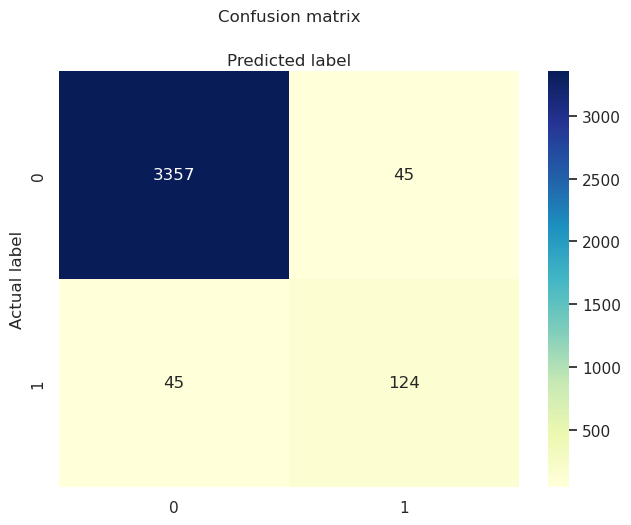

AttributeError: predict_proba is not available when  probability=False

In [192]:
#using SVM as the classifier to model the dataset and predict the target column
#using all varibles and keywords as the features and fraudulent as the target
#using the count vectorizer to convert the keywords to numerical values
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df['keywords'])
#adding remaining columns to the dataset by using the hstack function
from scipy.sparse import hstack
X = hstack((X, df[['employment_type','required_experience','required_education','industry','function']]))

y = df['fraudulent']
#splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#using the SVM classifier to train the model with all the features
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train, y_train)
#predicting the results
y_pred = classifier.predict(X_test)
#calculating the accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))
#calculating the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# saving the accuracy and precision score and recall score and f1 score in the score dictionary
scores['accuracy2'] = accuracy_score(y_test, y_pred)
scores['precision2'] = precision_score(y_test, y_pred)
scores['recall2'] = recall_score(y_test, y_pred)
scores['f12'] = f1_score(y_test, y_pred)
#visualizing the SVM model curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=['Not Fraudulent', 'Fraudulent'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [166]:
t = scores
t

{'accuracy': 0.9798375805096612,
 'precision': 0.8702290076335878,
 'recall': 0.6745562130177515,
 'f1': 0.76,
 'accuracy1': 0.955474656958835,
 'precision1': 0.5337837837837838,
 'recall1': 0.46745562130177515,
 'f11': 0.49842271293375395,
 'accuracy2': 0.9747969756370765,
 'precision2': 0.7337278106508875,
 'recall2': 0.7337278106508875,
 'f12': 0.7337278106508875}

In [171]:
#using score dictionary to create a dataframe and plot the accuracy, precision, recall and f1 score of the three models
performance = pd.DataFrame(columns= ['accuracy', 'precision', 'recall', 'f1'], index=['Logistic Regression', 'Naive Bayes', 'SVM'])
performance.loc['Logistic Regression'] = [t['accuracy'], t['precision'], t['recall'], t['f1']]
performance.loc['Naive Bayes'] = [t['accuracy1'], t['precision1'], t['recall1'], t['f11']]
performance.loc['SVM'] = [t['accuracy2'], t['precision2'], t['recall2'], t['f12']]
performance

,accuracy,precision,recall,f1
Logistic Regression,0.979838,0.870229,0.674556,0.76
Naive Bayes,0.955475,0.533784,0.467456,0.498423
SVM,0.974797,0.733728,0.733728,0.733728


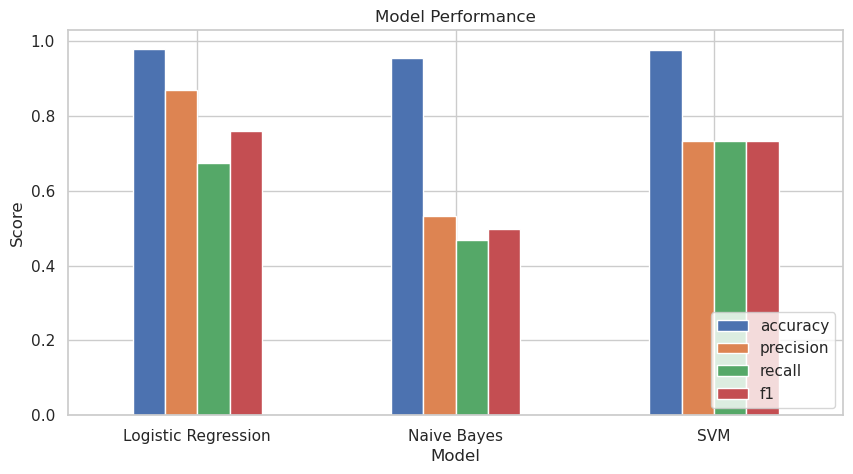

In [194]:
#plotting the accuracy, precision, recall and f1 score of the three models
def plot_model_performance(model_performance):
    model_performance.plot(kind='bar', figsize=(10, 5))
    plt.title('Model Performance')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.xticks(rotation=0)
    plt.show()
plot_model_performance(performance)

In [183]:
#calculating the total time taken to write the code and run the code
end = time.time()

print('total time taken to run the code: ', round((end-start)/60), 'minutes')

total time taken to run the code:  98 minutes
